In [72]:
from IPython.display import clear_output
%pip install pandas numpy torch opencv-python torchvision tqdm scikit_learn
clear_output()

In [84]:
import pandas as pd 
import numpy as np 
import os
from PIL import Image

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import cv2

from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [85]:
dataset_path = 'data/caxton_dataset'

caxton = pd.read_csv(os.path.join(dataset_path,'caxton_dataset_full.csv'))
# caxton = caxton[(caxton['print_id'] < 1) | (caxton['print_id'] > 190)]
caxton.head(3)

,img_path,timestamp,flow_rate,feed_rate,z_offset,target_hotend,hotend,bed,nozzle_tip_x,nozzle_tip_y,print_id
0,caxton_dataset/print0/image-1.jpg,2020-10-08T13:12:48-02,100,100,0.0,205.0,204.34,65.66,531,554,0
1,caxton_dataset/print0/image-2.jpg,2020-10-08T13:12:48-48,100,100,0.0,205.0,204.34,65.66,531,554,0
2,caxton_dataset/print0/image-3.jpg,2020-10-08T13:12:48-94,100,100,0.0,205.0,204.13,65.74,531,554,0


In [86]:
!nvidia-smi

Tue Jul 30 20:33:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  |   00000000:88:00.0 Off |                  N/A |
| 27%   47C    P2             71W /  250W |    7914MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [87]:
import gc

def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

clear_gpu_memory()

print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e6:.2f} MB")
print(f"GPU memory cached: {torch.cuda.memory_reserved()/1e6:.2f} MB")

GPU memory allocated: 584.12 MB
GPU memory cached: 977.27 MB


# Labeling

In [88]:
def create_binary_label(row):
    print_id = row['print_id']
    return 1 if print_id >= 183 else 0  # 1 for failure, 0 for non-failure

caxton['failure'] = caxton.apply(create_binary_label, axis=1)

<Axes: xlabel='failure'>

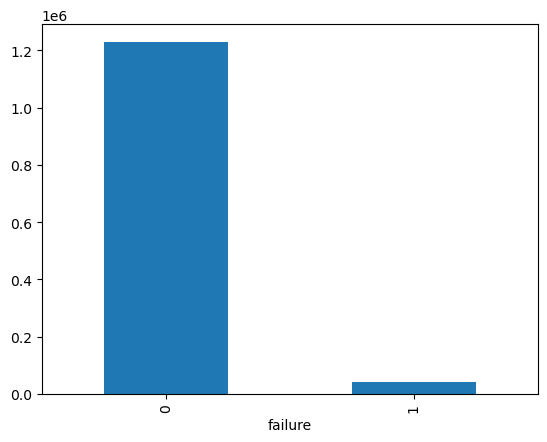

In [89]:
caxton['failure'].value_counts().plot(kind='bar', y='failure')

# Dataset Preperation

In [93]:
class VideoDataset(Dataset):
    def __init__(self, data, transform=None, max_frames=100, frame_interval=3):
        self.data = data
        self.transform = transform
        self.max_frames = max_frames
        self.frame_interval = frame_interval
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        print_id = self.data.iloc[idx]['print_id']
        img_path = self.data.iloc[idx]['img_path']
        label = 1 if print_id >= 183 else 0
        
        print_dir = os.path.dirname(os.path.join('data', img_path))
        frame_files = sorted([f for f in os.listdir(print_dir) if f.endswith('.jpg')])
        
        # Sampling strategy
        total_frames = len(frame_files)
        if total_frames <= self.max_frames:
            sampled_files = frame_files[::self.frame_interval][:self.max_frames]
        else:
            interval = max(self.frame_interval, total_frames // self.max_frames)
            sampled_files = frame_files[::interval][:self.max_frames]
        
        frames = []
        for frame_file in sampled_files:
            full_img_path = os.path.join(print_dir, frame_file)
            img = Image.open(full_img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            frames.append(img)

        frames_tensor = torch.stack(frames)
        return frames_tensor, label, len(frames)

In [94]:
# Set random seed for reproducibility
torch.manual_seed(42)

batch_size = 2
accumulation_steps = 4  # Number of steps to accumulate gradients

# CNN hyperparameters
input_channels = 3  # RGB images
num_classes = 1 # Binary classification (normal vs failure)
learning_rate = 1e-3
num_epochs = 3
dropout_rate = 0.5

# Define image dimensions
img_height = 224
img_width = 224

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_height, img_width)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# LSTM hyperparameters
lstm_hidden_size = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [96]:
train_df, test_df = train_test_split(caxton, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42) 

# Create datasets
max_frames = 300  # Adjust this based on your GPU memory and desired maximum sequence length
train_dataset = VideoDataset(train_df, transform=transform, max_frames=max_frames)
val_dataset = VideoDataset(val_df, transform=transform, max_frames=max_frames)
test_dataset = VideoDataset(test_df, transform=transform, max_frames=max_frames)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [97]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        
        # Use a smaller pre-trained model
        self.efficientnet = models.efficientnet_b0(weights='DEFAULT')
        
        # Remove the last fully connected layer
        self.features = nn.Sequential(*list(self.efficientnet.children())[:-1])
        
        # Freeze the CNN parameters
        for param in self.features.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        return self.features(x)

    
class SequenceProcessor(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate):
        super(SequenceProcessor, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x, lengths):
        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (h_n, c_n) = self.lstm(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Use the last output for each sequence
        last_output = output[torch.arange(output.size(0)), lengths - 1]
        out = self.fc(last_output)
        
        return out
    
class VideoCNNLSTM(nn.Module):
    def __init__(self, input_channels, num_classes, lstm_hidden_size, dropout_rate):
        super(VideoCNNLSTM, self).__init__()
        
        self.feature_extractor = FeatureExtractor()
        
        # Get the number of features from the CNN
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, 224, 224)
            cnn_output = self.feature_extractor(dummy_input)
            cnn_output_size = cnn_output.view(-1).shape[0]
        
        self.sequence_processor = SequenceProcessor(
            input_size=cnn_output_size,
            hidden_size=lstm_hidden_size,
            num_classes=num_classes,
            dropout_rate=dropout_rate
        )
        
    def forward(self, x, lengths):
        batch_size, max_len, C, H, W = x.size()
        c_in = x.view(batch_size * max_len, C, H, W)
        
        # CNN forward pass
        c_out = self.feature_extractor(c_in)
        
        # Reshape for LSTM input
        r_in = c_out.view(batch_size, max_len, -1)
        
        # Sequence processing
        out = self.sequence_processor(r_in, lengths)
        
        return out

In [98]:
model = VideoCNNLSTM(
    input_channels=input_channels,
    num_classes=num_classes,
    lstm_hidden_size=lstm_hidden_size,
    dropout_rate=dropout_rate
).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    optimizer.zero_grad()
    for batch, (inputs, labels, lengths) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)
        
        outputs = model(inputs, lengths)
        loss = criterion(outputs.squeeze(), labels.float())
        loss = loss / accumulation_steps
        loss.backward()
        
        if (batch + 1) % accumulation_steps == 0 or (batch + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()
        
        train_loss += loss.item() * accumulation_steps
        predicted = (torch.sigmoid(outputs) > 0.5).squeeze()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    
    train_loss /= len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels, lengths in tqdm(val_loader, desc="Validation"):
            inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)
            outputs = model(inputs, lengths)
            loss = criterion(outputs.squeeze(), labels.float())
            
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).squeeze()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    print()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/jadhaiza/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:01<00:00, 11.5MB/s]
/home/jadhaiza/miniconda3/envs/ka/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Epoch 1/3:   0%|                                                                                         | 41/381682 [04:36<714:58:38,  6.74s/it]


RuntimeError: Caught RuntimeError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/home/jadhaiza/miniconda3/envs/ka/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jadhaiza/miniconda3/envs/ka/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/jadhaiza/miniconda3/envs/ka/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 316, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jadhaiza/miniconda3/envs/ka/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 173, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jadhaiza/miniconda3/envs/ka/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 141, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jadhaiza/miniconda3/envs/ka/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 213, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects each tensor to be equal size, but got [220, 3, 224, 224] at entry 0 and [300, 3, 224, 224] at entry 1


In [ ]:
# Testing
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels, lengths in tqdm(test_loader, desc="Testing"):
        inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)
        outputs = model(inputs, lengths)
        loss = criterion(outputs.squeeze(), labels.float())
        
        test_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).squeeze()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:48<00:00,  2.42s/it]
